# Closed kinematic chain hopper, using minimal coordinates

<center>
<img src="../diagrams/leg-model.svg" width="40%" />
<br/>
Model of the leg
</center>

In [1]:
import sympy as sp
import numpy as np
import physical_education as pe

%load_ext autoreload
%autoreload 2

vec = lambda *args: sp.Matrix(args)
simplify = lambda m: pe.utils.parsimp(m, nprocs=2, f=sp.simplify)
trigsimp = lambda m: pe.utils.parsimp(m, nprocs=2, f=sp.trigsimp)

## Define variables and constants

In [2]:
sym = lambda s: sp.Symbol(s, real=True)
constants_mapping = {
    # body
    sym('m_b'): 4.1,
    sym('l_b'): 0.15,

    # upper link
    sym('m_1'): 0.090,
    sym('l_1'): 0.1375,

    # lower link
    sym('m_2'): 0.090,
    sym('l_2'): 0.250,

    # gravity
    sym('g'): 9.81,
}
mb, lb, m1, l1, m2, l2, g = constants_mapping.keys()

# foot
m3, l3x, l3y = sp.symbols('m_3 l_3x l_3y', real=True)

mb, lb, m1, l1, m2, l2, g

In [3]:
full_simp = lambda x: simplify(x.subs(constants_mapping).evalf())

Ib, I1, I2 = mb*(lb**2 + lb**2)/12, (m1*l1**2)/12, (m2*l2**2)/12
# Ib = 0

# two input torques
τl, τr = sp.Matrix(sp.symbols('\\tau_:2', real=True))
u = vec(τl, τr)

# two ground reaction forces
Lx, Ly = sp.symbols('L_x L_y', real=True)

In [4]:
# the states of the leg
def sym_and_derivs(symbol: str):
    return sp.symbols(r'%s \dot{%s} \ddot{%s}' % (symbol, symbol, symbol), real=True)

full_system = False

if full_system:
    xb, dxb, ddxb = sym_and_derivs('x')
    yb, dyb, ddyb = sym_and_derivs('y')
else:
    xb = dxb = ddxb = yb = dyb = ddyb = 0

thul, dthul, ddthul = sym_and_derivs('\\theta_{ul}')
thur, dthur, ddthur = sym_and_derivs('\\theta_{ur}')

if full_system:
    q   = vec(  xb,   yb,   thul,   thur)
    dq  = vec( dxb,  dyb,  dthul,  dthur)
    ddq = vec(ddxb, ddyb, ddthul, ddthur)
    Bu  = vec(   0,    0,     τl,     τr)
else:
    q   = vec(  thul,   thur)
    dq  = vec( dthul,  dthur)
    ddq = vec(ddthul, ddthur)
    Bu  = vec(    τl,     τr)

# q, dq, ddq, Bu

In [5]:
def time_derivative(vector: sp.Matrix, state=vec(*q, *dq), state_deriv=vec(*dq, *ddq)):
    return vector.jacobian(state) @ state_deriv

def time_derivative_matrix(matrix: sp.Matrix, **kwargs):
    n, m = matrix.shape
    return time_derivative(matrix.reshape(n*m, 1), **kwargs).reshape(n, m)

## Find positions

In [6]:
def get_lower_leg_eqns():
    th_ll_sym, th_lr_sym = sp.symbols('th_ll th_lr')

    a = thul - thur
    b = thur + (180 - th_lr_sym)
    c = th_ll_sym + (180 - thul)
    d = 360 - (a + b + c)

    thll, thlr = sp.solve([
        b - c,
        sp.Eq(
            2*l1**2 * (1 - sp.cos(a)),
            2*l2**2 * (1 - sp.cos(d))
        )
    ], (th_ll_sym, th_lr_sym))[0]
    
    dthll, dthlr = vec(thll, thlr).jacobian([thul, thur]) @ vec(dthul, dthur)
    
    return simplify(vec(thll, thlr, dthll, dthlr))

In [7]:
thll, thlr, dthll, dthlr = get_lower_leg_eqns()

# def make_plot(thur, thul, thlr, thll, l1, l2):
#     import matplotlib.pyplot as plt
#     from math import sin, cos
#     plt.style.use('seaborn')

#     xlk, ylk = cos(thul)*l1, sin(thul)*l1
#     xlf, ylf = xlk + cos(thll)*l2, ylk + sin(thll)*l2
#     xrk, yrk = cos(thur)*l1, sin(thur)*l1
#     xrf, yrf = xrk + cos(thlr)*l2, yrk + sin(thlr)*l2
#     plt.plot([0, xlk, xlf], [0, ylk, ylf])
#     plt.plot([0, xrk, xrf], [0, yrk, yrf])
#     plt.show()

# _mapping = {thul: 0, thur: 1, l1: 1.5, l2: 1}
# f = lambda x: float(x.subs(_mapping).evalf())
# make_plot(0, 1, f(thll), f(thlr), 1.5, 1)

In [8]:
from physical_education.utils import rot

# the base
thb = 0
Pb_I = vec(xb, yb)
Rb_I = rot(thb).T

# connection between base and top links
conn_b = Pb_I

conn_ls = conn_b #+ Rb_I @ Mat([-rb/2, 0])
conn_rs = conn_b #+ Rb_I @ Mat([ rb/2, 0])

# the top links (shoulder to knee)
Pul_ul = vec(l1/2, 0)
Rul_I = rot(thul).T
Pul_I = simplify(conn_ls + Rul_I @ Pul_ul)

conn_lk = conn_ls + Rul_I @ vec(l1, 0)

Pur_ur = vec(l1/2, 0)
Rur_I = rot(thur).T
Pur_I = simplify(conn_rs + Rur_I @ Pur_ur)

conn_rk = conn_rs + Rur_I @ vec(l1, 0)

# the bottom links (knee to foot)
Pll_ll = vec(l2/2, 0)
Rll_I = rot(thll).T
Pll_I = simplify(conn_lk + Rll_I @ Pll_ll)

Plr_lr = vec(l2/2, 0)
Rlr_I = rot(thlr).T
Plr_I = simplify(conn_rk + Rlr_I @ Plr_lr)

# ankle
conn_la = conn_lk + Rll_I @ vec(l2, 0)
conn_ra = conn_rk + Rlr_I @ vec(l2, 0)

# foot
foot_offset = Rlr_I @ vec(l3y, l3x)
conn_lf = conn_la + foot_offset
conn_rf = conn_ra + foot_offset

# feet should be the same, whether you come from the left or right side
assert all(-0.001 < float(x) < 0.001
           for x in full_simp((conn_lf - conn_rf).subs({thul: -2, thur: -1})))

In [11]:
# # left/right knee, ankle, foot
# def make_plot2(lk, rk, la, ra, lf, rf, mapping):
#     import matplotlib.pyplot as plt
#     plt.style.use('seaborn')
#     f = lambda x: map(float, x.subs(mapping).evalf())
    
#     xlk, ylk = f(lk)
#     xrk, yrk = f(rk)
#     xla, yla = f(la)
#     xra, yra = f(ra)
#     xlf, ylf = f(lf)
#     xrf, yrf = f(rf)
#     plt.plot([0, xlk, xla, xlf], [0, ylk, yla, ylf], label='thl')
#     plt.plot([0, xrk, xra, xrf], [0, yrk, yra, yrf], label='thr')
#     plt.legend()
#     plt.axis('equal')
#     plt.show()

# # note: plot treats the x/y offset of the foot as one thing,
# #       so don't expect to see a right angle there
# make_plot2(conn_lk, conn_rk, conn_la, conn_ra, conn_lf, conn_rf,
#            {thul: -2, thur: -1, l3x: 0.02, l3y: 0.02, **constants_mapping})

## Define energies and calculate parts of manipulator equation

In [12]:
# calculate the system's kinetic and potential energy
Ps = [Pb_I, Pul_I, Pur_I, Pll_I, Plr_I] # foot?
Rs = [Rb_I, Rul_I, Rur_I, Rll_I, Rlr_I] # foot?
dths = [ 0, dthul, dthur, dthll, dthlr] # foot?
Is = [  Ib,    I1,    I1,    I2,    I2] # foot?
ms = [  mb,    m2,    m2,  0*m2,  0*m2] # foot?

dxy = [P.jacobian(q) @ dq for P in Ps]

Ek = vec(sp.trigsimp(sum(
    0.5*m*(dx**2 + dy**2) + 0.5*I*dth**2
        for m, I, (dx, dy), dth in zip(ms, Is, dxy, dths)
)))

Ep = vec(sp.trigsimp(sum(
    m*g*y for m, (_, y) in zip(ms, Ps)
)))

sp.count_ops(Ek), sp.count_ops(Ep)

In [13]:
# manipulator equation parts: mass matrix, coriolis, gravity/NC force
M, C, G = pe.utils.manipulator_equation(Ek, Ep, q, dq)

M = trigsimp(M)
C = trigsimp(C)
G = trigsimp(G)

sp.count_ops(M), sp.count_ops(C), sp.count_ops(G)

## Define foot in cartesian $\left(x,~y \right)$ and polar $\left(r,~\theta \right)$ coordinates

Polar coordinates gives us a "virtual leg" of sorts

The following three lines work, but don't simplify fully to be "mathematically correct" (nonsense!) or the simplest possible, so it's better to just write the equation out by hand:

```python
xf, yf = foot
rp = sp.sqrt(yf**2 + xf**2)
thp = sp.atan(yf / xf)  # atan2?
```

### NOTE: this excludes `l3x` and `l3y`. Fix!!!!!!!!!!!!!!!!!!

In [31]:
# contact
def getfoot_cartesian_polar():
    from sympy import sin, cos, sqrt
    th1 = thur
    th2 = thul
    diff = (th1 - th2)/2

    rp = simplify(vec(
        l1 * cos(diff) + sqrt(l2**2 - l1**2 * sin(diff)**2)
    ))
    thp = (th1 + th2)/2

    # return cartesian and polar coordinate vectors
    return vec(rp * cos(thp), rp * sin(thp)), vec(rp, thp)

foot, foot_polar = getfoot_cartesian_polar()
J_L = foot.jacobian(q)
L = vec(Lx, Ly)

# check that we get the same results for cartesian
f = lambda x: list(map(float, full_simp(x.subs({thul: -2, thur: -1, l3x: 0, l3y: 0}))))
assert np.allclose(f(foot), f(conn_lf))

foot_polar

⎡                                        _____________________________________
⎢      ⎛\theta_{ul}   \theta_{ur}⎞      ╱     2    2⎛\theta_{ul}   \theta_{ur}
⎢l₁⋅cos⎜─────────── - ───────────⎟ +   ╱  - l₁ ⋅sin ⎜─────────── - ───────────
⎢      ⎝     2             2     ⎠   ╲╱             ⎝     2             2     
⎢                                                                             
⎢                              \theta_{ul}   \theta_{ur}                      
⎢                              ─────────── + ───────────                      
⎣                                   2             2                           

________⎤
⎞     2 ⎥
⎟ + l₂  ⎥
⎠       ⎥
        ⎥
        ⎥
        ⎥
        ⎦

# Impedance control

First, we decide on an output $y$ to control. We could choose $y = \begin{bmatrix} \theta_1 \\ \theta_2 \end{bmatrix}$ to control leg angles, or $y = \begin{bmatrix} r \\ \theta \end{bmatrix}$ to control the position of the foot in polar coordinates

-----

Next, we differentiate the output $y = f(q)$ until we get to the "control input" level. In mechanical systems, this is at the acceleration level, after differentiating twice: $$\ddot{y} = f(q, \dot{q}, \ddot{q})$$ because $\ddot{q}$ is a function of $u$, but $q$ and $\dot{q}$ aren't

In [26]:
# y = vec(thul, thur)
y = foot_polar

dy = simplify(time_derivative(y))

ddy = simplify(time_derivative(dy))

y, dy, ddy

⎛                                                                             
⎜                                                                             
⎜⎡                                               _____________________________
⎜⎢      ⎛\theta_{ul}   \theta_{ur}⎞             ╱     2    2⎛\theta_{ul}   \th
⎜⎢l₁⋅cos⎜─────────── - ───────────⎟ + l_3y +   ╱  - l₁ ⋅sin ⎜─────────── - ───
⎜⎢      ⎝     2             2     ⎠          ╲╱             ⎝     2           
⎜⎢                                                                            
⎜⎢                                 \theta_{ul}   \theta_{ur}                  
⎜⎢                                 ─────────── + ───────────                  
⎜⎣                                      2             2                       
⎜                                                                             
⎜                                                                             
⎝                                                   

Now, let $$\ddot{y} = f(q, \dot{q}, \ddot{q}) = v$$ where $v$ is a pseudo control input. Setting $v$ will set the "dynamics" ($\ddot{y}$) of our output - for example, we could make it behave like a spring-damper system by controlling it with a PD controller: $$v = k_p e + e_d \dot{e}$$ where $e = v_{setpoint} - v$. Bear in mind that $v = \ddot{y}$ is essentially a double integrator $\left( \frac{1}{s^2} \right)$

-----

So we know how to calculate $v$, which determines $\ddot{y}$. The next step is to map that to the _actual_ control inputs ($u$), which we do in two stages:

First, solve $\ddot{y} = v = f(q, \dot{q}, \ddot{q})$ for $\ddot{q}$, where $v$ is calculated as above

Doing that the naive/simple way (as in `sp.solve(ddy - ddysetpoint, ddthul, ddthur)`) takes aaaages, but we can speed things up by noticing that

$$\dot{y} = J_y ~ \dot{q}$$
$$\ddot{y} = J_y ~ \ddot{q} + \dot{J}_y ~ \dot{q}$$
where $J_y$ is the Jacobian of $y$ with respect to $q$, and $\dot{J}_y$ is the time derivative of $J_y$

Solving:
$$ \ddot{q} = J_y^{-1} (\ddot{y} - \dot{J}_y ~ \dot{q})$$

We can do this symbolically in this example, but if doing so isn't possible for a given system, the steps from here onwards can be done numerically (ie calculate `ddq = J_y \ (ddy - dJy @ dq)`)

In [27]:
Jy = simplify(y.jacobian(q))
dJy = simplify(time_derivative_matrix(Jy))

In [32]:
ddysetpoint = ddrs, ddths = vec(*sp.symbols(f'ddr_setpoint ddth_setpoint'))

# the line below is the same as `Jy.inv() @ (ddy - dJy * dq)`, but faster
ddq_eqn = full_simp(
    Jy.solve(ddysetpoint - dJy * dq)
)

# should only contain these symbols
assert ddq_eqn.free_symbols.issubset({thul, dthul, thur, dthur, ddrs, ddths})

print(sp.count_ops(ddq_eqn))

ddq_eqn

564


──────────────────────────────────
                                                                              
597⋅sin(\theta_{ul} - \theta_{ur}) + 0.00101101077962424⋅sin(2⋅\theta_{ul} - 2
                                                                              
                                                                              
                              2                                               
653395286822⋅\dot{\theta_{ur}} ⋅(0.17820324005891⋅cos(\theta_{ul} - \theta_{ur
                                                                              
──────────────────────────────────────────────────────────────────────────────
_{ur}⎞                        ⎛3⋅\theta_{ul}   3⋅\theta_{ur}⎞                 
─────⎟ + 0.170264141367037⋅sin⎜───────────── - ─────────────⎟ + 0.007939098691
     ⎠                        ⎝      2               2      ⎠                 

                                2                                             
50314584132038⋅\

In [33]:
# sp.count_ops(Jy) + sp.count_ops(ddysetpoint - dJy * dq), sp.count_ops(ddq_eqn)

In [34]:
# # test:
# ddy_test = simplify(
#     Jy@ddq + dJy@dq
# )
# should_equal_zero = simplify(sp.trigsimp(sp.expand(
#     ddy_test - ddy
# )))
# assert all(expr == 0 for expr in should_equal_zero)

Next, we solve the equations of motion ($M\ddot{q} + C\dot{q} + G = B u + Q + A^T F$) to get $u$

Again, to do this performantly, we should solve the `Ax=b` version: $B \tau = M\ddot{q} + C\dot{q} + G - Q - J_L^T L$

_However_, since our system has $B = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$, we can just calculate $\tau = M\ddot{q} + C\dot{q} + G - Q - J_L^T L$ directly

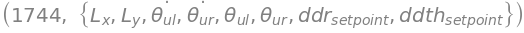

In [35]:
torque_input = full_simp(
    M @ ddq_eqn + C + G - J_L.T @ L
)

sp.count_ops(torque_input), torque_input.free_symbols

The ODrive does [current control, not torque control](https://docs.odriverobotics.com/#current-control) (although that's changing [in a new version](https://github.com/madcowswe/ODrive/blob/v0.5.1-rc5/Firmware/odrive-interface.yaml#L955)). For now we need to map current to torque via a torque constant $K_t$

In [36]:
Kt = sp.Symbol('Kt')
current_input = 1/Kt * torque_input

Great - calculate `current_input` and we're done. We could lambdify a function (which should be fast enough -- see timing below) but if it isn't, it could be worth using `numba`:
- https://numba.readthedocs.io/en/stable/user/5minguide.html
- https://numba.readthedocs.io/en/stable/reference/aot-compilation.html)

In [37]:
current_lambdified = sp.lambdify(
    [ddrs, ddths, thul, thur, dthul, dthur, Lx, Ly, l3x, l3y, Kt],
    (current_input[0], current_input[1]))

test = current_lambdified(1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11.)
assert isinstance(test, tuple) and all(isinstance(t, float) for t in test)

Otherwise we can just write the function to disk:

In [40]:
cm = constants_mapping

pycode = f"""# generated by impedance-control.ipynb
import math, typing

def impedance_control(
        ddr_setpoint: float, ddth_setpoint: float,
        th_ul: float, th_ur: float,
        dth_ul: float, dth_ur: float,
        L_x: float, L_y: float,
        l3x: float, l3y: float,
        Kt: float
    ) -> typing.Tuple[float, float]:
    \"\"\"
    Masses and lengths:
    mb = {cm[mb]:.3f}kg, m1 = {cm[m1]:.3f}kg, m2 = {cm[m2]:.3f}kg
    rb = {cm[lb]:.3f} m, r1 = {cm[l1]:.3f} m, r2 = {cm[l2]:.3f} m
    g = {cm[g]:.3f}m/s^2
    
    Kt is the torque constant
    l3x and l3y are lengths of the foot in meters
    \"\"\"
    # motor0, motor1
    current_input = (
        {sp.pycode(current_input[0])},
        {sp.pycode(current_input[1])},
    )
    return current_input
""".replace('\\theta_','th_').replace('{', '').replace('}', '').replace(r'\dot', 'd')

with open('./controller_generated.py', 'w') as f:
    f.write(pycode)

# print(pycode)

In [41]:
from controller_generated import impedance_control
import math

test_input = np.random.random(11)  # 11 inputs

for lamb, disk in zip(current_lambdified(*test_input), impedance_control(*test_input)):
    if not math.isclose(lamb, disk):
        print('got different values:', lamb, disk, lamb-disk, test_input)

In [42]:
from timeit import timeit

N = 1000

tlambdify = timeit('current_lambdified(1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.)',
                   number=N, globals=globals())/N
twritetodisk = timeit('impedance_control(1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.)',
                      number=N, globals=globals())/N
# twritetodisk = timeit('impedance_control(ddr_setpoint=1.,ddth_setpoint=2.,th_ul=3.,th_ur=4.,dth_ul=5.,dth_ur=6.,L_x=7.,L_y=8.,Kt=9.)',
#                       number=N, globals=globals())/N

print(f'lambdify: {tlambdify*1000} ms | write to disk: {twritetodisk*1000} ms')

lambdify: 0.7549823120061774 ms | write to disk: 0.06706262999796309 ms


and that's that! Writing to disk is much faster

In [43]:
rth = full_simp(foot_polar)
drth = full_simp(time_derivative(foot_polar))

assert rth.free_symbols.issubset({thul, thur})
assert drth.free_symbols.issubset({thul, thur, dthul, dthur})

# rth, drth

In [45]:
cm = constants_mapping

pycode = f"""

def foot_state_polar(
        th_ul: float, th_ur: float,
        dth_ul: float, dth_ur: float,
        l3x: float, l3y: float,
    ) -> typing.Tuple[float, float, float, float]:
    \"\"\"
    Masses and lengths:
    mb = {cm[mb]:.3f}kg, m1 = {cm[m1]:.3f}kg, m2 = {cm[m2]:.3f}kg
    rb = {cm[lb]:.3f} m, r1 = {cm[l1]:.3f} m, r2 = {cm[l2]:.3f} m
    g = {cm[g]:.3f}m/s^2
    l3x and l3y are lengths of the foot in meters
    \"\"\"
    # r, th, dr, dth
    foot_state_polar = (
        {sp.pycode(rth[0])},
        {sp.pycode(rth[1])},
        {sp.pycode(drth[0])},
        {sp.pycode(drth[1])},
    )
    return foot_state_polar
""".replace('\\theta_','th_').replace('{', '').replace('}', '').replace(r'\dot', 'd')

with open('./controller_generated.py', 'a') as f:
    f.write(pycode)

# print(pycode)

-----
-----
-----
# Forward simulation

In [ ]:
# rhs = (
#     C + G - Bu - J_L.T @ L
# ).subs(constants_mapping).evalf()

# args = [*q, *dq, *u, Lx, Ly]
# assert rhs.free_symbols.issubset(set(args))

# dynamics_rhs = sp.lambdify(args, rhs)

In [ ]:
# dynamics_lhs = sp.lambdify([thul, thur], M)

In [ ]:
# np.linalg.solve(dynamics_lhs(1, 2), dynamics_rhs(*[1]*len(args)))

In [ ]:
# ddq_f = (
#     M.solve(rhs)
#     # M @ ddq + C + G - B - J_L.T @ L
# )

# # ddq_f = pe.utils.parsimp(ddq_f, nprocs=4, f=sp.trigsimp)
# # ddq_f = pe.utils.parsimp(ddq_f, nprocs=4, f=sp.simplify)

# # ddq_f

# Attic

In [ ]:
# def getb():
#     fr = Rl_I @ vec(0, -Fr)
#     rr = Pl_I
#     Qr = (fr.T @ rr.jacobian(q)).T

#     fth = Mat([Fth])
#     rth = Mat([thb-thl])
#     Qth = (fth.T @ rth.jacobian(q)).T

#     return Qr + Qth

# B = getb().jacobian(u)

In [ ]:
# # Jacobian and time derivative
# A = foot.jacobian(q)  # or: conn_rf, conn_lf
# dA = time_derivative_matrix(A)
# # dA = sp.zeros(*A.shape)

# # constraint forces
# # Mi = M.inv()
# # λ = -(A @ Mi @ A.T).inv() * (A @ Mi @ (B + Q - C - G) + dA @ dq)
# # λ = -inv(A*inv(M)*transpose(A))*(A*inv(M)*(B + Q - C - G) + dA*dq)
# # λ = sp.simplify(λ)

# # eqn = M@ddq + C + G - B - Q - A.T*λ
# # eqn = sp.simplify(eqn)

# A#, dA

In [ ]:
# # sp.init_printing(wrap_line=True) #     num_columns: int or None

# # B_ = B.jacobian(u)
# # B_inv = sp.inv_quick(B_.T @ B_) @ B_.T

# assert B_inv @ B_ == Mat([[1, 0], [0, 1]])